In [1]:
import pandas as pd
import warnings
from Bio import BiopythonParserWarning
from datasets import load_dataset
from genplasmid.datasets import read_genbank

# Suppress the specific warning
warnings.filterwarnings("ignore", category=BiopythonParserWarning, message="Attempting to parse malformed locus line:")


/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_dataset("wconnell/openplasmid", trust_remote_code=True)
data

DatasetDict({
    train: Dataset({
        features: ['Name', 'ID', 'Flame', 'Purpose', 'Depositing Lab', 'Publication', 'GenBank File', 'Sequence Type', 'GenBank Raw', 'Backbone', 'Growth in Bacteria', 'Terms and Licenses', 'References', 'Gene/Insert 1', 'Cloning Information for Gene/Insert 1', 'Gene/Insert 2', 'Cloning Information for Gene/Insert 2', 'Gene/Insert 3', 'Cloning Information for Gene/Insert 3'],
        num_rows: 147071
    })
})

In [5]:
record = read_genbank(data['train'][0]['GenBank Raw'])
record

SeqRecord(seq=Seq('GGAACGGCTCCGCCCACTATTAATGAAATTAAAAATTCCAATTTTAAAAAACGC...CCA'), id='.', name='sequence-52055-e', description='synthetic circular DNA', dbxrefs=[])

In [45]:
data['train'][10000]['GenBank Raw'] == ''

False

In [36]:
from Bio.Seq import Seq
from collections import defaultdict

def analyze_features(record, plasmid_id):
    feature_data = []
    motifs = defaultdict(list)
    
    for feature in record.features:
        if feature.type != 'source':
            feature_data.append({
                'ID': plasmid_id,
                'type': feature.type,
                'length': len(feature),
                'strand': feature.strand,
            })
            
            if feature.type in ['promoter', 'primer_bind', 'CDS', 'rep_origin', 'enhancer', 'polyA_signal', 'protein_bind']:
                sequence = str(feature.extract(record.seq))
                if len(sequence) > 0:
                    motifs[feature.type].append(sequence)
    
    return feature_data, motifs

# Analyze all records
all_feature_data = []
all_motifs = defaultdict(list)

for x in data['train']:
    record = x['GenBank Raw']
    if record != '':
        record = read_genbank(record)
        feature_data, motifs = analyze_features(record, x['ID'])
        all_feature_data.extend(feature_data)
        for feature_type, sequences in motifs.items():
            all_motifs[feature_type].extend(sequences)

# Convert feature data to DataFrame
feature_df = pd.DataFrame(all_feature_data)

# # Function to find common motifs
# def find_common_motifs(sequences, min_length=6, max_length=20, min_occurrence=0.5):
#     from collections import Counter
    
#     all_motifs = []
#     for seq in sequences:
#         for i in range(len(seq) - min_length + 1):
#             for j in range(min_length, min(max_length, len(seq) - i + 1)):
#                 all_motifs.append(seq[i:i+j])
    
#     motif_counts = Counter(all_motifs)
#     common_motifs = [motif for motif, count in motif_counts.items() 
#                      if count >= min_occurrence * len(sequences)]
    
#     return sorted(common_motifs, key=lambda x: motif_counts[x], reverse=True)[:10]

# # Find and print common motifs for each feature type
# for feature_type, sequences in all_motifs.items():
#     print(f"\nCommon motifs for {feature_type}:")
#     common_motifs = find_common_motifs(sequences)
#     for motif in common_motifs:
#         print(f"  {motif}")


/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/Bio/SeqFeature.py:231: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


Number of records with sequences: 2380


In [51]:
print(f"Records with sequences: {feature_df['ID'].nunique()}")

Records with sequences: 138784


Text(0.5, 0.98, 'Feature Analysis Across Dataset')

<Axes: xlabel='type'>

Text(0.5, 1.0, 'Feature Type Counts')

Text(0.5, 0, 'Feature Type')

Text(0, 0.5, 'Count')

<Axes: xlabel='type'>

Text(0.5, 1.0, 'Average Feature Lengths')

Text(0.5, 0, 'Feature Type')

Text(0, 0.5, 'Average Length (bp)')

<Axes: ylabel='count'>

Text(0.5, 1.0, 'Strand Distribution')

Text(0, 0.5, '')

<Axes: xlabel='type', ylabel='length'>

Text(0.5, 1.0, 'Feature Length Distribution (Top 10 features)')

Text(0.5, 0, 'Feature Type')

Text(0, 0.5, 'Length (bp)')

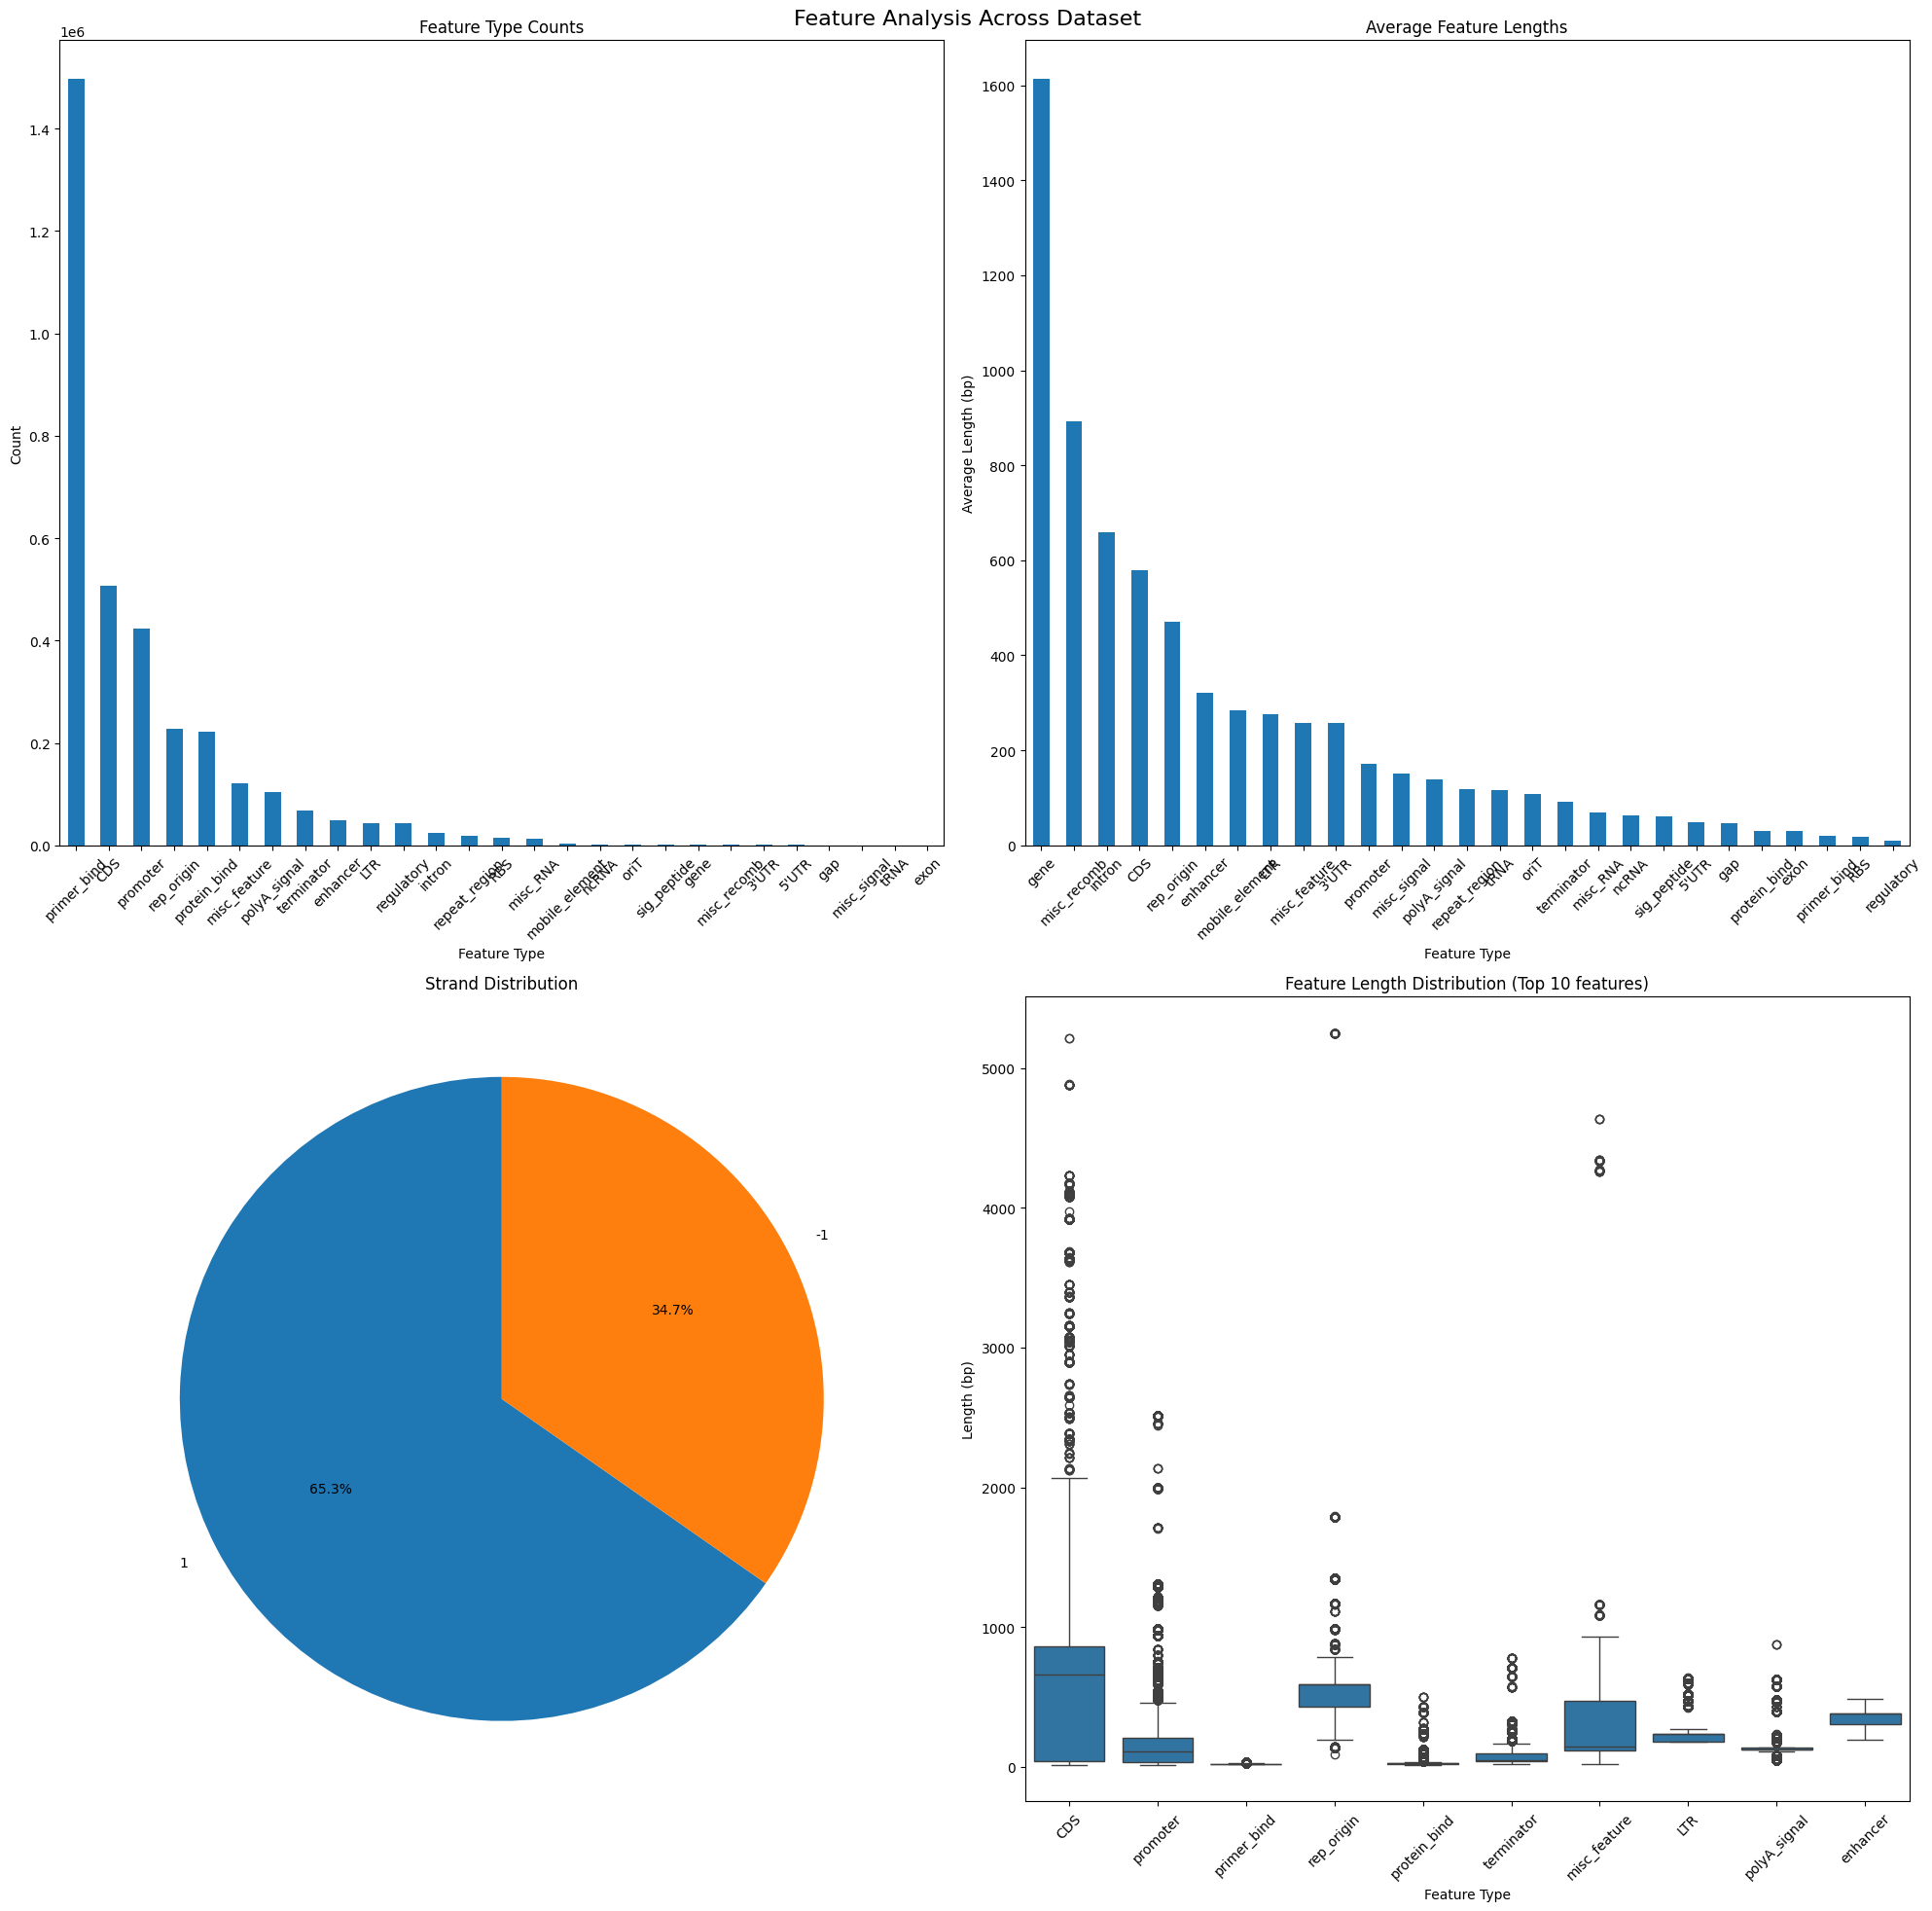


Feature type counts:
type
primer_bind       1497847
CDS                506437
promoter           422638
rep_origin         226843
protein_bind       221989
misc_feature       121344
polyA_signal       103871
terminator          67264
enhancer            49300
LTR                 43931
regulatory          42656
intron              24833
repeat_region       17833
RBS                 15367
misc_RNA            11959
mobile_element       2401
ncRNA                2028
oriT                 2012
sig_peptide          1307
gene                 1144
misc_recomb           924
3'UTR                 716
5'UTR                 646
gap                   228
misc_signal           164
tRNA                   76
exon                    5
Name: count, dtype: int64

Average feature lengths:
type
gene              1614.234266
misc_recomb        893.503247
intron             659.490517
CDS                579.493447
rep_origin         470.187733
enhancer           321.216998
mobile_element     283.797584
LTR 

In [52]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Feature Analysis Across Dataset', fontsize=16)

# 1. Feature Type Counts
feature_counts = feature_df['type'].value_counts()
feature_counts.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Feature Type Counts')
axes[0, 0].set_xlabel('Feature Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Average Feature Lengths
avg_lengths = feature_df.groupby('type')['length'].mean().sort_values(ascending=False)
avg_lengths.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Average Feature Lengths')
axes[0, 1].set_xlabel('Feature Type')
axes[0, 1].set_ylabel('Average Length (bp)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Strand Distribution
strand_counts = feature_df['strand'].value_counts()
strand_counts.plot(kind='pie', ax=axes[1, 0], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Strand Distribution')
axes[1, 0].set_ylabel('')

# 4. Feature Length Distribution (Top 10 features)
top_10_features = feature_counts.head(10).index
sns.boxplot(x='type', y='length', data=feature_df[feature_df['type'].isin(top_10_features)], ax=axes[1, 1])
axes[1, 1].set_title('Feature Length Distribution (Top 10 features)')
axes[1, 1].set_xlabel('Feature Type')
axes[1, 1].set_ylabel('Length (bp)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print additional summary statistics
print("\nFeature type counts:")
print(feature_counts)

print("\nAverage feature lengths:")
print(avg_lengths)

print("\nStrand counts:")
print(strand_counts)